In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from strategy_tester import Backtesting
from model_loader import ModelLoader
from sklearn.metrics import classification_report

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-19 19:21:24.528321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-19 19:21:24.528575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-19 19:21:24.556682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-19 19:21:24.662818: I tensorflow/core/platform/cpu_feature_guard.cc:18

In [2]:
def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4
    )

SELECCIÓN DEL MEJOR MODELO PRE-ENTRENADO

In [3]:
# 1) Leer el archivo de métricas y elegir el mejor modelo
metrics_path = '../../score_models/model_comparison_metrics.csv'
df = pd.read_csv(metrics_path, index_col='model')
best_model_name = df['trend_change_f1_score'].idxmax()
print(f"Mejor modelo según trend_change_f1_score: {best_model_name}")

# # 2) Construir la ruta del archivo del modelo según el tipo
# base_dir = '../../score_models/models' 
# model_file = None

# # Buscar el archivo del modelo en el directorio
# for fname in os.listdir(base_dir):
#     if fname.startswith(best_model_name):
#         model_file = os.path.join(base_dir, fname)
#         break

# if model_file is None:
#     raise FileNotFoundError(f"No se encontró archivo de modelo para '{best_model_name}' en {base_dir}")

# print(f"Usando archivo de modelo: {model_file}")

# 3) Instanciar y cargar el modelo
# loader = ModelLoader(best_model_name)
model = best_model_name

Mejor modelo según trend_change_f1_score: LightGBM


In [4]:
# Cargar datos
train = pd.read_csv("../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../data/post_cleaning/test_set.csv", parse_dates=['date'])

# Concatenar los dataframes de entrenamiento y validación
train_val_set = pd.concat([train, val], ignore_index=True)

CARGA Y PREPARACIÓN DE DATOS

In [5]:
# Preparar los arrays de numpy para la clase Backtesting
# Se pasa el conjunto combinado. La división se hará dentro de la clase Backtesting.
X_train_val = train_val_set.drop(columns=["date", "target_trend"]).values
y_train_val = train_val_set["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

Ejecución del Backtesting con Walk-Forward Optimization

In [6]:
# 1. Configuración de parámetros del backtesting
initial_capital = 10000.0 # Capital inicial para la simulación
window_size = 5 # Número de días en cada ventana de prueba antes de re-optimizar.
optuna_trials_initial_step = 700 # 700 Número de trials de Optuna en el primer paso (más intensivo).
optuna_trials_per_step = 150 # 150 Número de trials para los pasos de re-optimización siguientes.

# 2. Instanciar la clase Backtesting con los datos y la configuración.
bt = Backtesting(
    best_model_name, # Se pasa el nombre del modelo a usar.
    X_train_val, y_train_val, X_test, y_test, test_set,
    window_size=window_size,
    initial_capital=initial_capital,
    optuna_trials_initial=optuna_trials_initial_step,
    optuna_trials=optuna_trials_per_step
)

# Ejecutar el método que contiene toda la lógica del backtesting
# Devuelve el historial de la cartera y métricas clave de la simulación.
#backtest_df = bt.run()
backtest_df, X_train_current, y_train_current_m = bt.run()

# Extraer métricas de la estrategia principal para el análisis
num_buys = bt.num_buys_executed
num_sells = bt.num_sells_executed

# 3. Cálculo de los resultados finales de la estrategia principal.
final_portfolio_value = backtest_df['walk_forward_portfolio'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100


Walk-Forward Backtesting:   0%|          | 0/295 [00:00<?, ?it/s][I 2025-09-19 19:21:26,817] A new study created in memory with name: no-name-94c60291-8a6f-4740-aacd-c16a98a78570
[I 2025-09-19 19:21:28,722] Trial 0 finished with value: 0.4189189189189189 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.4189189189189189.
[I 2025-09-19 19:21:29,359] Trial 1 finished with value: 0.4520547945205479 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_data_in_leaf': 25}. Best is trial 1 with value: 0.4520547945205479.
[I 2025-09-19 19:21:30,208] Trial 2 finished with value: 0.4383561643835616 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves':

In [7]:
# Convertir X_train_current a un DataFrame con nombres de columnas
column_names = train_val_set.drop(columns=["date","target_trend"]).columns  # Usar las mismas columnas que train_val_set
X_train_current_df = pd.DataFrame(X_train_current, columns=column_names)

# Mostrar las últimas filas del DataFrame
print("\nX_train_current actualizado como DataFrame:")
print(X_train_current_df.tail(20))


X_train_current actualizado como DataFrame:
       open_d-4      MA_d-4    RSI_d-4     MACD_d-4  trend_d-4  \
1648   94733.68   95006.203  61.273718  2739.896875        0.0   
1649   96834.02   95226.805  67.929950  2751.721986        1.0   
1650   97030.50   95554.926  68.492833  2761.183802        1.0   
1651  103261.61   96379.969  80.532823  2861.788771        1.0   
1652  102971.99   97251.486  78.974265  3003.103311        1.0   
1653  104809.53   98315.239  81.498464  3184.998077        1.0   
1654  104118.00   99078.049  77.602800  3364.500306        1.0   
1655  102791.32   99668.468  70.426796  3504.258354        1.0   
1656  104103.72  100493.198  73.155281  3624.730834        1.0   
1657  103507.83  101416.220  69.901652  3709.031555        1.0   
1658  103763.71  102319.223  70.527074  3761.870119        1.0   
1659  103463.90  102982.211  68.669435  3778.861570        1.0   
1660  103126.65  103591.826  66.480840  3758.500608        1.0   
1661  106454.27  103911.092  75

In [8]:
print("\n--- Resultados del Backtesting (Walk-Forward Optimization) ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"\nValor Final del Portafolio con Walk-Forward Optimization: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
buy_and_hold_portfolio_value = backtest_df['buy_and_hold_portfolio'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_portfolio_value - initial_capital) / initial_capital * 100
print(f"\nValor Final del Portafolio con Estrategia Buy & Hold: ${buy_and_hold_portfolio_value:,.2f}")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")
dca_portfolio_value = backtest_df['dca_portfolio'].iloc[-1]
dca_return_pct = (dca_portfolio_value - initial_capital) / initial_capital * 100
print(f"\nValor Final del Portafolio con Estrategia Dollar Cost Averaging (DCA): ${dca_portfolio_value:,.2f}")
print(f"Retorno de Dollar Cost Averaging (DCA): {dca_return_pct:.2f}%")


--- Resultados del Backtesting (Walk-Forward Optimization) ---
Capital Inicial: $10,000.00

Valor Final del Portafolio con Walk-Forward Optimization: $17,409.00
Retorno Total de la Estrategia: 74.09%

Valor Final del Portafolio con Estrategia Buy & Hold: $17,117.30
Retorno de Comprar y Mantener (Buy & Hold): 71.17%

Valor Final del Portafolio con Estrategia Dollar Cost Averaging (DCA): $13,273.72
Retorno de Dollar Cost Averaging (DCA): 32.74%


In [9]:
# 4. Análisis de Operaciones

print("\n--- Análisis de Operaciones Reales ---")
print(f"Número de COMPRAS ejecutadas: {num_buys}")
print(f"Número de VENTAS ejecutadas: {num_sells}")
print(f"Número total de transacciones: {num_buys + num_sells}")


--- Análisis de Operaciones Reales ---
Número de COMPRAS ejecutadas: 19
Número de VENTAS ejecutadas: 18
Número total de transacciones: 37


In [10]:
# 5. Métricas de Clasificación sobre todo el Backtest

# Extraer las predicciones y los valores reales del período de backtesting
y_pred_backtest = backtest_df['signal'].values
y_true_backtest = test_set.loc[backtest_df.index, 'target_trend'].values

print("\n--- Métricas de Clasificación del Backtest Completo ---")

# Reporte de clasificación estándar (predicción de tendencia -1, 0, 1)
print("\nReporte de Clasificación (Tendencia):")
print(classification_report(y_true_backtest, y_pred_backtest, digits=4, zero_division=0))

# Reporte de clasificación de cambio de tendencia (predicción de True/False)
print("\nReporte de Cambio de Tendencia:")
print(trend_changes_score(y_true_backtest, y_pred_backtest))


--- Métricas de Clasificación del Backtest Completo ---

Reporte de Clasificación (Tendencia):
              precision    recall  f1-score   support

          -1     0.7273    0.8800    0.7964       100
           0     0.5000    0.1944    0.2800        36
           1     0.8438    0.8491    0.8464       159

    accuracy                         0.7797       295
   macro avg     0.6903    0.6412    0.6409       295
weighted avg     0.7623    0.7797    0.7603       295


Reporte de Cambio de Tendencia:
              precision    recall  f1-score   support

       False     0.8223    0.8767    0.8486       227
        True     0.4615    0.3582    0.4034        67

    accuracy                         0.7585       294
   macro avg     0.6419    0.6174    0.6260       294
weighted avg     0.7401    0.7585    0.7471       294



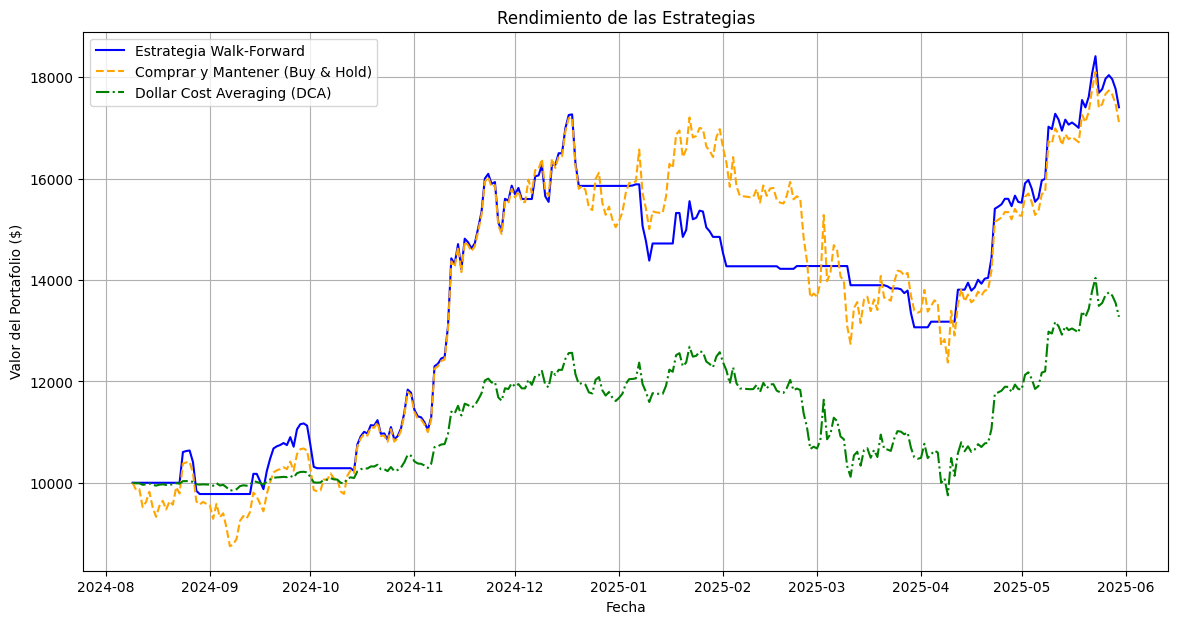

In [11]:
# 6. Visualización
plt.figure(figsize=(14, 7))

# Graficar las 3 estrategias directamente desde el DataFrame de resultados
plt.plot(backtest_df['date'], backtest_df['walk_forward_portfolio'], label='Estrategia Walk-Forward', color='blue')
plt.plot(backtest_df['date'], backtest_df['buy_and_hold_portfolio'], label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')
plt.plot(backtest_df['date'], backtest_df['dca_portfolio'], label='Dollar Cost Averaging (DCA)', color='green', linestyle='-.')

plt.title('Rendimiento de las Estrategias')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()